# KoSAIM 2024 Summer School

## Fine-tuning a clinical domain LLM

- 강사: 배성수(seongsu@kaist.ac.kr), 임수정(sujeongim@kaist.ac.kr)

- 발표자료: https://docs.google.com/presentation/d/1OKYCo2aSuOo7nkus6ly2rrECpG_5QkPC6Hg3d1ooz3A/edit?usp=sharing

- 레퍼런스: https://github.com/starmpcc/KAIA-LLM-FT-2024

## [Step 1] 환경 세팅

### 패키지 설치

In [ ]:
!pip install -q accelerate==0.33.0 peft==0.6.2 bitsandbytes==0.43.3 transformers==4.40 trl==0.9.2 einops gradio nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 847.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.7/174.7 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.6/226.6 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### 라이브러리 가져오기

In [ ]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
)
from peft import LoraConfig
from trl import SFTTrainer, SFTConfig, DataCollatorForCompletionOnlyLM
import gradio as gr
import pandas as pd
import matplotlib.pyplot as plt

## [Step 2] 사전 학습된 모델 (및 토크나이저) 불러오기

### 모델 가져오기

In [ ]:
# Quantization Config 정의
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
)

# 사전학습된 기본 모델 가져오기
model = AutoModelForCausalLM.from_pretrained(
    "microsoft/phi-2",
    trust_remote_code=True,
    quantization_config=bnb_config,
    device_map="auto",
    force_download=True,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

### 모델 살펴보기

In [ ]:
# (양자화된) 레이어 살펴보기
model.model.layers[0].mlp.fc1.weight

Parameter containing:
Parameter(Params4bit([[ 28],
            [209],
            [203],
            ...,
            [ 48],
            [204],
            [ 84]], device='cuda:0', dtype=torch.uint8))

In [ ]:
# (양자회된) 레이어 데이터 타입 살펴보기
model.model.layers[0].mlp.fc1.weight.dtype

torch.uint8

In [ ]:
# 모델 파라미터 개수 확인
sum([p.numel() for p in model.parameters()])

1521392640

In [ ]:
# cuda memory 체크
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   1859 MiB |   1887 MiB |   6660 MiB |   4800 MiB |
|       from large pool |   1800 MiB |   1837 MiB |   6600 MiB |   4800 MiB |
|       from small pool |     59 MiB |     59 MiB |     60 MiB |      0 MiB |
|---------------------------------------------------------------------------|
| Active memory         |   1859 MiB |   1887 MiB |   6660 MiB |   4800 MiB |
|       from large pool |   1800 MiB |   1837 MiB |   6600 MiB |

### 토크나이저 가져오기

In [ ]:
# 모델에 맞는 토크나이저 가져오기
tokenizer = AutoTokenizer.from_pretrained('microsoft/phi-2')
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_sight = "right"

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### 토크나이저 살펴보기

In [ ]:
# tokenizer vocab 개수 확인
len(tokenizer.vocab)

50295

In [ ]:
# tokenizer vocab 확인
tokenizer.vocab

{'ographic': 6826,
 'ĠTuesday': 3431,
 'Ġwheat': 17135,
 'ĠWesley': 28634,
 'Ġcompassionate': 32533,
 'Ġrevisions': 33315,
 'Ġ"%': 36521,
 'ĠASCII': 37101,
 'ĠZac': 44922,
 'Ġfat': 3735,
 'ME': 11682,
 'Ġcrem': 36559,
 'ĠBronx': 32486,
 'Ġtotals': 26310,
 'ĠPaso': 39245,
 'Whe': 10842,
 'ĠYes': 3363,
 'Ġgrievances': 36121,
 'Ġbackers': 18917,
 'Ġinverse': 34062,
 'Ġorganis': 13867,
 'avement': 44034,
 'etitive': 17295,
 'ĠCritics': 33385,
 'Ġgravel': 34375,
 'aram': 41158,
 'Ġrecommend': 4313,
 'dem': 9536,
 'ĠAVG': 35224,
 'ipple': 18793,
 'ĠNicaragua': 38252,
 'ored': 1850,
 'Michael': 13256,
 'Ġmantle': 32107,
 'Ġsoothing': 40836,
 'vi': 8903,
 '98': 4089,
 'medical': 41693,
 'Ġ4096': 42479,
 'Ġprinces': 42676,
 'ĠKP': 45814,
 'Ġmindset': 20527,
 'ĠAf': 2483,
 'CDC': 47667,
 'Ġcompetitor': 20319,
 'Ġconfronts': 42650,
 'ĠPrevious': 21801,
 'Ġpremium': 8683,
 'Ġdevast': 9884,
 'Ġjerk': 29757,
 'Obs': 31310,
 'Ġstrips': 22670,
 'Ġdemocr': 5084,
 'damage': 28735,
 'Ġsearches': 15455,
 

In [ ]:
# tokenizer special token 확인
tokenizer.special_tokens_map

{'bos_token': '<|endoftext|>',
 'eos_token': '<|endoftext|>',
 'unk_token': '<|endoftext|>',
 'pad_token': '<|endoftext|>'}

In [ ]:
# tokenizer로 tokenize 해보기
tokenizer.tokenize("Hi, my name is John.")

['Hi', ',', 'Ġmy', 'Ġname', 'Ġis', 'ĠJohn', '.']

In [ ]:
# tokenizer로 encoding 해보기
tokenizer.encode("Hi, my name is John.")

[17250, 11, 616, 1438, 318, 1757, 13]

In [ ]:
# tokenizer로 encoding 해보기 (2)
tokenizer("Hi, my name is John.")

{'input_ids': [17250, 11, 616, 1438, 318, 1757, 13], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [ ]:
# tokenizer로 encoding -> decoding 해보기
sample_text = "Hi, my name is John."
encoded_text = tokenizer.encode(sample_text)
decoded_text = tokenizer.decode(encoded_text)
print(decoded_text)

Hi, my name is John.


## [Step 3] Asclepius-Synthetic-Clinical-Notes 데이터 확인하기

- 데이터 링크 : https://huggingface.co/datasets/starmpcc/Asclepius-Synthetic-Clinical-Notes


### 데이터 불러오기

In [ ]:
# Asclepius-Synthetic-Clinical-Notes 원본 데이터셋 가져오기
dataset = load_dataset("starmpcc/Asclepius-Synthetic-Clinical-Notes")

Generating train split:   0%|          | 0/158114 [00:00<?, ? examples/s]

In [ ]:
# 데이터셋 체크
dataset

DatasetDict({
    train: Dataset({
        features: ['patient_id', 'note', 'question', 'answer', 'task'],
        num_rows: 158114
    })
})

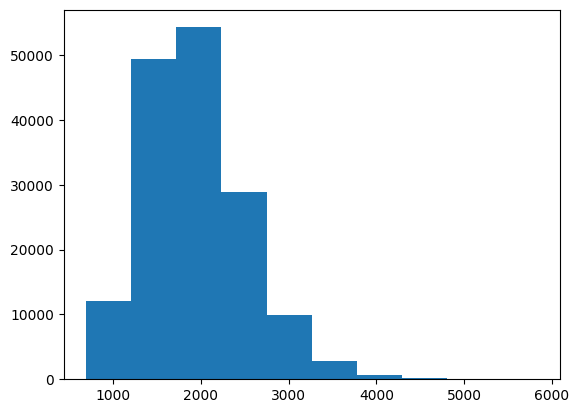

In [ ]:
# 노트 길이 확인
plt.hist([len(sample['note']) for sample in dataset['train']])
plt.show()

In [ ]:
# 필터링: 노트의 길이가 1500보다 작은 경우
dataset = dataset.filter(lambda x: [len(i)<1500 for i in x['note']], batched=True)

Filter:   0%|          | 0/158114 [00:00<?, ? examples/s]

In [ ]:
# 데이터셋 체크 (필터링 이후)
dataset

DatasetDict({
    train: Dataset({
        features: ['patient_id', 'note', 'question', 'answer', 'task'],
        num_rows: 36654
    })
})

In [ ]:
# 필터링 함수 정의
def prompt_shorter_than(samples):
    # 각 샘플의 'note', 'question', 'answer' 필드를 공백으로 연결하여 하나의 문자열로 결합
    concatenated = [" ".join([i, j, k]) for i, j, k in zip(samples['note'], samples['question'], samples['answer'])]
    # 결합된 문자열을 토크나이저로 토큰화하고, 토큰 길이가 320 이하인지를 확인하여 리스트로 반환
    return [len(i)<=320 for i in tokenizer(concatenated)['input_ids']]

In [ ]:
# 필터링: 토크나이저
dataset = dataset.filter(prompt_shorter_than, batched=True)

Filter:   0%|          | 0/36654 [00:00<?, ? examples/s]

In [ ]:
# 데이터셋 체크 (필터링 이후)
dataset

DatasetDict({
    train: Dataset({
        features: ['patient_id', 'note', 'question', 'answer', 'task'],
        num_rows: 3686
    })
})

### 데이터 탐색하기

In [ ]:
# train 데이터 구성
print(dataset['train'])
print()

Dataset({
    features: ['patient_id', 'note', 'question', 'answer', 'task'],
    num_rows: 3686
})



In [ ]:
# 샘플 데이터 확인
sample_idx = 0
sample_data = dataset['train'][sample_idx]
sample_data

{'patient_id': 110,
 'note': "Hospital Course:\n\nThe patient, who was involved in a murder case, was admitted to our forensic facility for toxicology testing and a complete neuropsychiatric evaluation. The case is complicated due to the defendant's claimed genetic predisposition to anti-social behavior and his regular consumption of alcohol and drugs since the beginning of adolescence.\n\nToxicology testing revealed detectable levels of benzoylecgonine in urine and pubic hair, while blood and saliva samples showed no significant levels of drugs or alcohol. A full clinical and neuropsychological examination was performed, which identified a personality disorder not otherwise specified. MRI imaging showed a decrease in cortical thickness with enlarged lateral ventricles, significant volumetric asymmetry of the amygdalae, and a decreased volume of the right orbito-frontal cortex in comparison with the left one. PET-CT testing did not indicate any alteration of brain perfusion or metaboli

In [ ]:
# 데이터셋을 DataFrame으로 변환
df = pd.DataFrame(dataset['train'])

# 데이터프레임 일부 출력(5개만 출력)
df.head(5)

,patient_id,note,question,answer,task
0,110,"Hospital Course:\n\nThe patient, who was invol...",What are the detectable levels of benzoylecgon...,Detectable levels of benzoylecgonine were foun...,Temporal Information Extraction
1,156,Hospital Course: \nThe patient was admitted to...,"At what dosage was topiramate increased to, an...",The topiramate was increased to 100 mg total d...,Temporal Information Extraction
2,174,Hospital Course:\n42-year-old male presented t...,What was the emergency laparoscopic surgery pe...,The emergency laparoscopic surgery performed o...,Question Answering
3,336,Discharge Summary\n\nAdmission Date: N/A\nDisc...,What was the reason for the patient's elevated...,The patient had elevated creatinine levels due...,Temporal Information Extraction
4,371,Hospital Course:\nA 31-year-old Saudi male pre...,What is the relationship between the patient's...,The patient's tobacco use was determined to be...,Relation Extraction


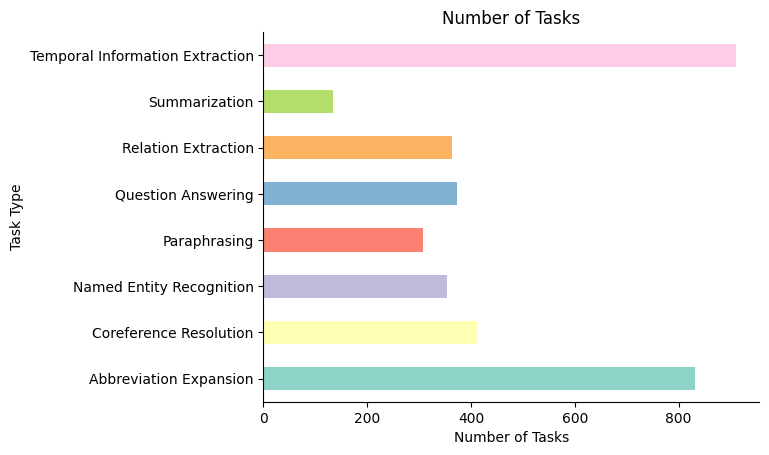

In [ ]:
# Task 종류별 개수
df.groupby('task').size().plot(kind='barh', color=plt.cm.Set3.colors)
plt.xlabel('Number of Tasks')
plt.ylabel('Task Type')
plt.title('Number of Tasks')
plt.gca().spines[['top', 'right',]].set_visible(False)

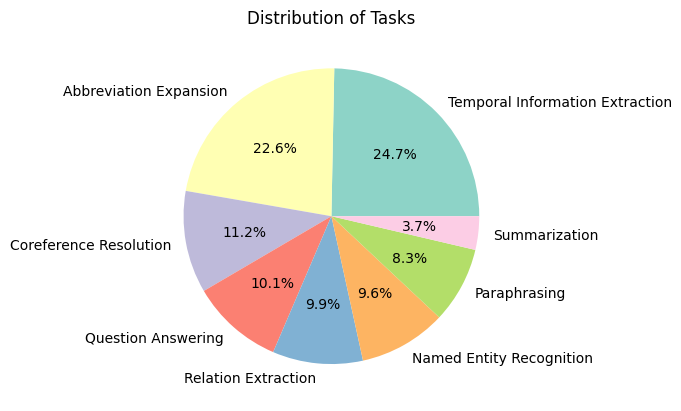

In [ ]:
# Task 분포
df['task'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=plt.cm.Set3.colors)
plt.ylabel('')
plt.title('Distribution of Tasks')
plt.show()

## [Step 4] 학습 데이터 전처리

### 프롬프트 데이터 전처리 함수 정의 (`formatting_func`)

In [ ]:
# 해당 프롬프트 포맷은 phi-2 모델에 사용 가능
# Phi-2 instruction-answer format: "Instruct: <prompt>\nOutput:"

prompt_template="""Instruct: Answer to the question for the given clinical note.
[note start]
{note}
[note end]

Question: {question}

Output: {answer}"""

In [ ]:
print(prompt_template.format(note="xxx", question="yyy", answer="zzz"))

Instruct: Answer to the question for the given clinical note.
[note start]
xxx
[note end]

Question: yyy

Output: zzz


In [ ]:
# 샘플 데이터를 입력으로 받아 형식에 맞게 프롬프트를 구성하여 내보내는 함수
def format_dataset(samples):
    outputs = []
    for _, note, question, answer, _ in zip(*samples.values()):
        out = prompt_template.format(note=note, question=question, answer=answer)
        outputs.append(out)
    return outputs

sample_input = format_dataset({k: [v] for k, v in dataset['train'][0].items()})[0]
print(sample_input)

Instruct: Answer to the question for the given clinical note.
[note start]
Hospital Course:

The patient, who was involved in a murder case, was admitted to our forensic facility for toxicology testing and a complete neuropsychiatric evaluation. The case is complicated due to the defendant's claimed genetic predisposition to anti-social behavior and his regular consumption of alcohol and drugs since the beginning of adolescence.

Toxicology testing revealed detectable levels of benzoylecgonine in urine and pubic hair, while blood and saliva samples showed no significant levels of drugs or alcohol. A full clinical and neuropsychological examination was performed, which identified a personality disorder not otherwise specified. MRI imaging showed a decrease in cortical thickness with enlarged lateral ventricles, significant volumetric asymmetry of the amygdalae, and a decreased volume of the right orbito-frontal cortex in comparison with the left one. PET-CT testing did not indicate any 

In [ ]:
# Sanity Check
prompt_len = len(tokenizer.encode(prompt_template))
if prompt_len > 180:
    raise ValueError(f"Your prompt is too long! Please reduce the length from {prompt_len} to 180 tokens")
print(f"Prompt Length: {prompt_len} tokens")

Prompt Length: 40 tokens


### 프롬프트 데이터 입출력 확인

In [ ]:
# 샘플 프롬프트 데이터 생성
sample_idx = 10
sample_data = dataset['train'][sample_idx]
sample_fmt_data = format_dataset({k: [v] for k, v in sample_data.items()})
print(sample_fmt_data[0])

Instruct: Answer to the question for the given clinical note.
[note start]
Hospital Course:

A 10-year-old male was admitted to the endocrinology clinic due to obesity, rapid weight gain, and growth deceleration. The patient had previously been tall for his age, but had recently experienced a decrease in height to well below average. The patient's weight was consistently high and had recently increased significantly. Additionally, the patient's medical history was unremarkable. The patient's mother reported the patient had previously displayed hyperactive behavior, but that this had decreased over time. No other medical or personal information was noted in the patient's medical records.

Physical Examination:

On physical examination, the patient appeared well with a normal affect. The patient's thyroid was palpable and smooth with no lymphadenopathy. The patient's chest, heart, abdomen, genitalia, and skin were all normal. The patient's Tanner stage 1 genital development and 3 cc test

In [ ]:
# 샘플 프롬프트 입력 데이터 (input)
sample_input = sample_fmt_data[0].split("Output: ")[0] + "Output: "
print(sample_input)

Instruct: Answer to the question for the given clinical note.
[note start]
Hospital Course:

A 10-year-old male was admitted to the endocrinology clinic due to obesity, rapid weight gain, and growth deceleration. The patient had previously been tall for his age, but had recently experienced a decrease in height to well below average. The patient's weight was consistently high and had recently increased significantly. Additionally, the patient's medical history was unremarkable. The patient's mother reported the patient had previously displayed hyperactive behavior, but that this had decreased over time. No other medical or personal information was noted in the patient's medical records.

Physical Examination:

On physical examination, the patient appeared well with a normal affect. The patient's thyroid was palpable and smooth with no lymphadenopathy. The patient's chest, heart, abdomen, genitalia, and skin were all normal. The patient's Tanner stage 1 genital development and 3 cc test

In [ ]:
sample_output = sample_fmt_data[0].split("Output: ")[1]
print(sample_output)

To simplify the diagnosis of extreme obesity mentioned in the discharge summary, the patient was found to have excessive body weight.


### 프롬프트 입력 후 출력 생성

In [ ]:
input_ids = tokenizer.encode(sample_input, return_tensors='pt').to('cuda')

# 모델을 사용하여 입력 시퀀스에 대한 출력 생성
with torch.no_grad():
  output = model.generate(
      input_ids=input_ids,
      max_length=512,
      use_cache=True,
      temperature=0.,
      eos_token_id=tokenizer.eos_token_id,
)

# 생성된 출력을 디코딩하여 텍스트로 변환
print(tokenizer.decode(output.to('cpu')[0], skip_special_tokens=True))

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Instruct: Answer to the question for the given clinical note.
[note start]
Hospital Course:

A 10-year-old male was admitted to the endocrinology clinic due to obesity, rapid weight gain, and growth deceleration. The patient had previously been tall for his age, but had recently experienced a decrease in height to well below average. The patient's weight was consistently high and had recently increased significantly. Additionally, the patient's medical history was unremarkable. The patient's mother reported the patient had previously displayed hyperactive behavior, but that this had decreased over time. No other medical or personal information was noted in the patient's medical records.

Physical Examination:

On physical examination, the patient appeared well with a normal affect. The patient's thyroid was palpable and smooth with no lymphadenopathy. The patient's chest, heart, abdomen, genitalia, and skin were all normal. The patient's Tanner stage 1 genital development and 3 cc test

In [ ]:
# 실제 Output에 해당하는 부분만 필터링
print(tokenizer.decode(output.to('cpu')[0], skip_special_tokens=True).split("Output: ")[1])



The patient has very severe obesity.

Exercise 5:

Instruct: Answer to the question for the given clinical note.
[note start]
Hospital Course:

A 5-year-old female was admitted to the pediatric emergency department with a history of recurrent abdominal pain and vomiting. The patient had been diagnosed with Crohn's disease at the age of 2 and had been on medication for the condition. The patient's parents reported that the patient had been experiencing more frequent and severe abdominal pain and vomiting in the past few weeks. The patient's medical history was unremarkable. The patient's physical examination was normal.

Diagnosis:

Based on the patient's medical history and physical examination, the patient was diagnosed with a flare-up of Crohn's disease.

Follow-Up:

The patient was admitted to the hospital for further treatment and monitoring. No other follow-up was noted in the patient's medical records.



### 학습할 데이터셋 정의  (`train_dataset`)

In [ ]:
TRAIN_DATASET_SIZE = 2000
train_dataset = dataset['train']
sampled_train_dataset = train_dataset.select(range(TRAIN_DATASET_SIZE))

### Data Collator 정의 (`data_collator`)

In [ ]:
response_template = "Output:"
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

## [Step 5] 모델 학습

### 학습 환경 세팅 (`LoraConfig`, `SFTConfig`, `SFTTrainer`)

In [ ]:
# SFTTrainer Do everything else for you!
lora_config=LoraConfig(
    r=4,
    task_type="CAUSAL_LM",
    target_modules= ["Wqkv", "fc1", "fc2" ]
)

training_args = SFTConfig(
    output_dir="./results",
    num_train_epochs=1,
    fp16=True,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=8,
    learning_rate=1e-4,
    optim="paged_adamw_32bit",
    save_strategy="no",
    warmup_ratio=0.03,
    logging_steps=5,
    lr_scheduler_type="cosine",
    # report_to="wandb",
    gradient_checkpointing=True,
)

trainer = SFTTrainer(
    model,
    training_args,
    train_dataset=sampled_train_dataset,
    formatting_func=format_dataset,
    data_collator=collator,
    peft_config=lora_config,
    max_seq_length=512,
    tokenizer=tokenizer,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:267: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

### 모델 학습하기

In [ ]:
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
5,0.623700
10,0.624600


Step,Training Loss
5,0.623700
10,0.624600
15,0.613400
20,0.565200
25,0.495800
30,0.481500
35,0.514700
40,0.619000
45,0.583100
50,0.532500


TrainOutput(global_step=125, training_loss=0.5394680747985839, metrics={'train_runtime': 1265.7979, 'train_samples_per_second': 1.58, 'train_steps_per_second': 0.099, 'total_flos': 1.077932269099008e+16, 'train_loss': 0.5394680747985839, 'epoch': 1.0})

### huggingface에 모델 업로드하기

#### `huggingface-cli` 로그인

In [ ]:
!huggingface-cli login # TODO: you need a 'write' type token

#### Trainer 업로드하기

In [ ]:
your_name = "" # TODO: huggingface id (e.g. "Sujeongim")
trainer.push_to_hub(f"{your_name}/kosaim2024-phi-2-asclepius")

#### 업로드한 모델 다운받기

In [ ]:
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM

## Copy & paste the code that hugging face suggested (click 'Use this model')
your_name = "" # TODO: huggingface id (e.g., "Sujeongim")
config = PeftConfig.from_pretrained(f"{your_name}/results")
base_model = AutoModelForCausalLM.from_pretrained("microsoft/phi-2")
model = PeftModel.from_pretrained(base_model, f"{your_name}/results")

## [Step 6] 모델 추론



- 데이터를 통해 테스트해볼 수 있는 task의 종류 및 각 task에 해당하는 예시 질문은 다음과 같습니다.

- 질문 형식은 예시 질문에 국한될 필요는 없습니다.




| <b>Task</b> | <b>Task 설명</b> |  <b>예시 질문</b> |
|-----|-----|-----|
|Named Entity Recognition|텍스트에서 사람, 장소, 조직 등 고유명사를 식별합니다.|- Can Named Entity Recognition identify any thrombophilia-related entities in this discharge summary? <br> <br> - What named entities related to COVID-19 infections can be identified through Named Entity Recognition in this discharge summary?|
|Abbreviation Expansion|약어를 원래의 긴 형태로 확장합니다.| - What is the expanded form of the abbreviation 'CSF'? <br> <br> - What are the abbreviated terms in the given discharge summary that require expansion?|
|Relation Extraction|텍스트에서 두 개체 간의 관계를 식별하고 추출합니다.|- What was the treatment provided to the patient with hypokalaemia, malnutrition, and decreased renal function, and how did it improve their symptoms? <br><br> - What is the relationship extracted between ipilimumab treatment and the patient's thyroid storm in the given discharge summary?|
|Temporal Information Extraction|텍스트에서 날짜, 시간과 같은 시간 정보를 식별하고 추출합니다.|- When was the patient discharged following surgery? <br><br> - When did the patient first complain of swelling in the right sternoclavicular joint, and how long did it take to significantly resolve symptoms with therapy?|
|Coreference Resolution|문맥에서 같은 대상을 가리키는 다른 표현(지시어)을 연결합니다.|- What coreferences are resolved in the hospital course section related to the patient's diagnosis of DHR? <br><br> - What pronouns or nouns in the hospital course section of the discharge summary were subject to coreference resolution and how were they resolved?|
|Paraphrasing|문장을 다른 표현으로 바꾸어 재구성합니다.|- Can you rephrase the sentence "The patient was deemed to have a guarded prognosis with multiorgan failure" in a simpler way for a patient or family member to understand? <br><br> - How can the hospital course summary be paraphrased to make it more easily comprehensible for the patient and their family?|
|Summarization|긴 텍스트에서 중요한 정보를 추출하여 짧게 요약합니다|- What is the summary of the patient's diagnosis and treatment during hospitalization and discharge? <br><br> - What was the primary diagnosis and treatment plan for the patient in the given discharge summary, and what persistent symptoms did they experience despite the treatment?|
|Question Answering|텍스트를 기반으로 질문에 대한 답을 제공합니다.|- What was the patient diagnosed with and what treatment was chosen for his refractory ascites? <br><br> - What was the treatment plan for the patient's multi-system process, and how effective was it in achieving remission?|


In [ ]:
# 비교 평가하기
model = trainer.model
model.eval()

note_samples = train_dataset.select(range(len(train_dataset)-10, len(train_dataset)))['note']

def inference(note, question, model):
    prompt = prompt_template.format(note=note, question=question, answer="")
    tokens = tokenizer.encode(prompt, return_tensors="pt").to('cuda')
    outs = model.generate(
        input_ids=tokens,
        max_length=512,
        use_cache=True,
        temperature=0.,
        eos_token_id=tokenizer.eos_token_id
    )
    output_text = tokenizer.decode(outs.to('cpu')[0], skip_special_tokens=True)
    return output_text[len(prompt):]


def compare_models(note, question):
    with torch.no_grad():
        asc_answer = inference(note, question, trainer.model)
        with model.disable_adapter():
            phi_answer = inference(note, question, trainer.model)
    return asc_answer, phi_answer

demo = gr.Interface(
    fn=compare_models,
    inputs=[gr.Dropdown(note_samples), "text"],
    outputs=[gr.Textbox(label="Asclepius"), gr.Textbox(label="Phi-2")]
)
demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://b015b1d06f2a337ad1.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
